# WeatherML

## Setup Notebook

### Import Libraries

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

### Set Constants

In [2]:
COLOR_MAPPING = {
    'none': 'red',
    'jacket-short': 'orange',
    'jacket-long': 'green',
    'coat': 'blue'
}

RANDOM_STATE = 17

MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

## Data Processing
Before I can do any sort of machine learning, I need to first examine my dataset
and preprocess it. This involves feature engineering and handling missing values.
First, I'm getting a high level overview of my data.

In [3]:
df = pd.read_csv('data/weather_data.csv')
print('# Records:', df.shape[0])
print('# Features:', df.shape[1])
df.head()

# Records: 630
# Features: 9


,Date,Time,Temp (°F),Feels Like (°F),Humidity (%),UV,Wind (mph),Gusts (mph),Outer Clothing
0,07/11/2023,13:55,80,80,44,9,4,NaN,none
1,07/12/2023,12:44,83,83,45,9,4,NaN,none
2,07/13/2023,20:15,75,78,79,0,4,NaN,none
3,07/17/2023,17:38,82,83,49,3,5,NaN,none
4,07/22/2023,18:03,75,76,58,2,4,NaN,none


I have **630** data records with **9** starting features (including the target variable).
I can also immediately see that *Gusts* has missing data that will need to be addressed.

### Remove Label Units
Here, I'm removing the units from the feature labels to make coding easier down the road.

In [4]:
label_map = {
    'Temp (°F)': 'Temp',
    'Feels Like (°F)': 'Feels Like',
    'Humidity (%)': 'Humidity',
    'Wind (mph)': 'Wind',
    'Gusts (mph)': 'Gusts',
}
df.rename(columns=label_map, inplace=True)

### Date Type Cleaning
I'm also converting *Humidity* percentages from integer representation to decimals.
I convert *Date* from a string to an actual `datetime` object as well.

In [5]:
# convert humidity to decimal percents
df['Humidity'] = df['Humidity'] / 100

# convert dates to datetime
df['Date'] = pd.to_datetime(df['Date'])

### Add Season Data
I created a new feature to encapsulate the season data. I'm using simplified logic
that assigns a season based on the month alone, rather than using exact dates based
on solstices (see https://www.weather.gov/cle/seasons)

In [6]:
def get_season(date: datetime) -> str:
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'

df['Season'] = [get_season(date_str) for date_str in df['Date']]

### Handle Missing Data
Next, I'll be handling missing data. First, I'll need to check which features
contain missing values.

In [7]:
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

Gusts    110
dtype: int64

We see that only *Gusts* has missing data records. Since I only have 630 records,
110 missing values is a pretty significant amount. Therefore, I want to find a way
to impute the missing data rather than drop the records. 

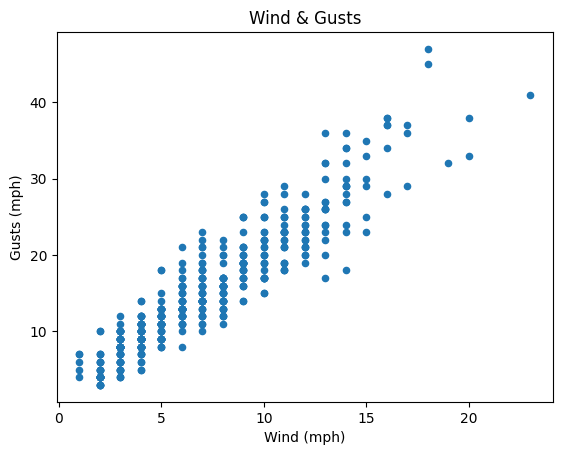

In [8]:
df_gust = df.copy()
df_gust = pd.get_dummies(df_gust, columns=['Season'])
df_gust.dropna().plot.scatter('Wind', 'Gusts')
plt.title('Wind & Gusts')
plt.xlabel('Wind (mph)')
plt.ylabel('Gusts (mph)');

This scatterplot indicates a linear relationship between Wind and Gusts. Therefore, 
I'll first try to use
Linear Regression and predict the *Gusts* value based on *Wind* speed.

MSE: 7.7802280324569315


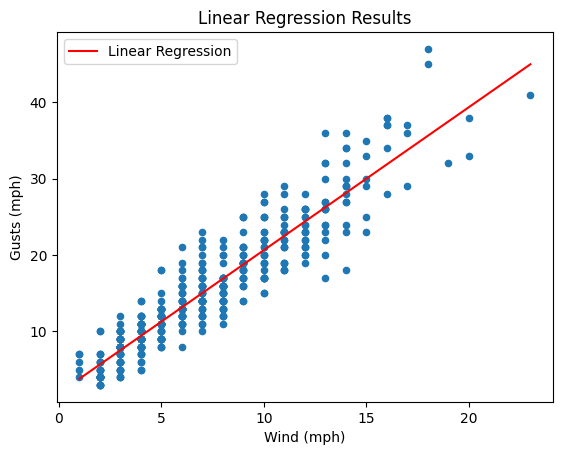

In [9]:
# prep data
non_missing = df_gust.dropna(subset=['Gusts'])
missing = df_gust[df_gust['Gusts'].isnull()]

X_train = non_missing[['Wind']].values
y_train = non_missing['Gusts'].values

# train model
lr_wind = LinearRegression()
lr_wind.fit(X_train, y_train)

# plot data points & regression line
print('MSE:', mean_squared_error(y_train, lr_wind.predict(X_train)))
m, b = lr_wind.coef_[0], lr_wind.intercept_
x_line = np.linspace(df_gust['Wind'].values.min(), df_gust['Wind'].values.max())
y_line = m * x_line + b
df_gust.dropna().plot.scatter('Wind', 'Gusts');
plt.plot(x_line, y_line, color='red', label='Linear Regression')
plt.title('Linear Regression Results')
plt.xlabel('Wind (mph)')
plt.ylabel('Gusts (mph)')
plt.legend();

Linear regression does a pretty good job approximating *Gusts* value from only the
*Wind* feature. However, if it used all the features for predictions rather
than just *Wind*, would accuracy improve?

In [10]:
X_train = non_missing.drop(columns=['Date', 'Time', 'Gusts', 'Outer Clothing']).values
y_train = non_missing['Gusts'].values

# train model
lr_all = LinearRegression()
lr_all.fit(X_train, y_train)

# plot data points & regression line
print('MSE:', mean_squared_error(y_train, lr_all.predict(X_train)))

MSE: 5.919092624972702


This gives a lower mean squared error (MSE) so I'll be using all features to predict
the missing *Gusts* data.

In [11]:
X_missing = missing.drop(columns=['Date', 'Time', 'Gusts', 'Outer Clothing']).values
df.loc[df['Gusts'].isnull(), 'Gusts'] = lr_all.predict(X_missing).round()
df.head()

,Date,Time,Temp,Feels Like,Humidity,UV,Wind,Gusts,Outer Clothing,Season
0,2023-07-11,13:55,80,80,0.44,9,4,8.0,none,Summer
1,2023-07-12,12:44,83,83,0.45,9,4,8.0,none,Summer
2,2023-07-13,20:15,75,78,0.79,0,4,8.0,none,Summer
3,2023-07-17,17:38,82,83,0.49,3,5,9.0,none,Summer
4,2023-07-22,18:03,75,76,0.58,2,4,8.0,none,Summer


## Data Analysis & Visualizations

### Target Class Distribution
I need to check the distribution for my labels since heavy class imbalances can
skew the results and metrics for my models.

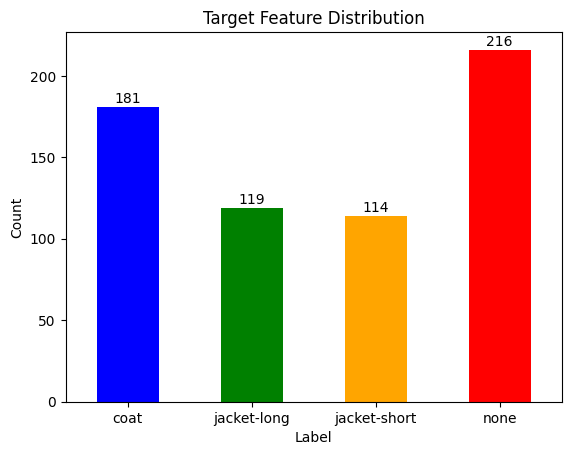

In [12]:
label_distr = df['Outer Clothing'].value_counts().sort_index()
colors = [COLOR_MAPPING[label] for label in label_distr.index]

ax = label_distr.plot(kind='bar', color=colors)
for i, count in enumerate(label_distr):
    ax.text(i, count + 5, f'{label_distr.iloc[i]}', ha='center', va='center')

plt.title('Target Feature Distribution')
plt.xticks(rotation=0)
plt.xlabel('Label')
plt.ylabel('Count');

Although it's not perfectly even, I don't believe these imbalances will significantly
affect my results.

### Time Distribution
Here, I check the distribution of target values across the months.

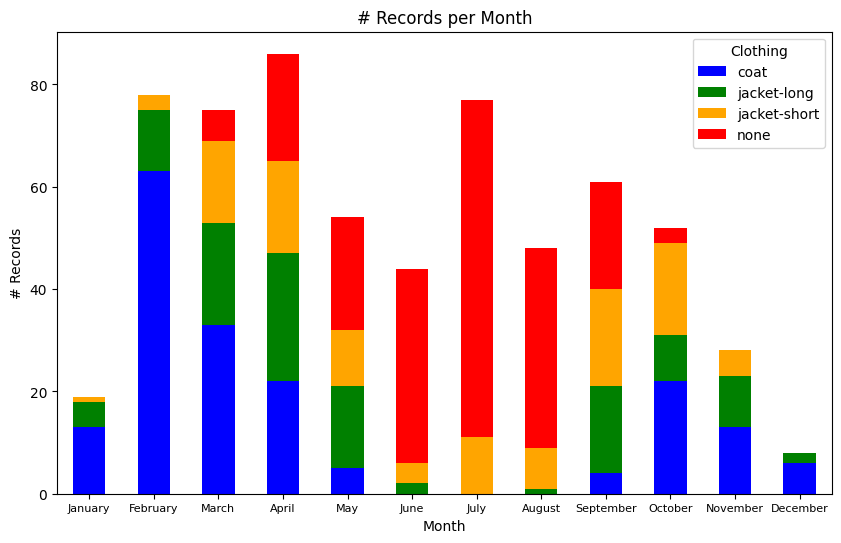

In [13]:
df_date = df[['Date', 'Outer Clothing']].copy()
df_date['Month'] = df_date['Date'].dt.month_name()
month_group = df_date.groupby(['Month', 'Outer Clothing']).size().reset_index(name='Count')
pivot = month_group.pivot(index='Month', columns='Outer Clothing', values='Count')
pivot = pivot.reindex(MONTHS)

ax = pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'green', 'orange', 'red'])
plt.title('# Records per Month')
plt.xlabel('Month')
plt.ylabel('# Records')
plt.xticks(rotation=0, size=8)
plt.legend(title='Clothing');

I can also repeat the process for the time of day.

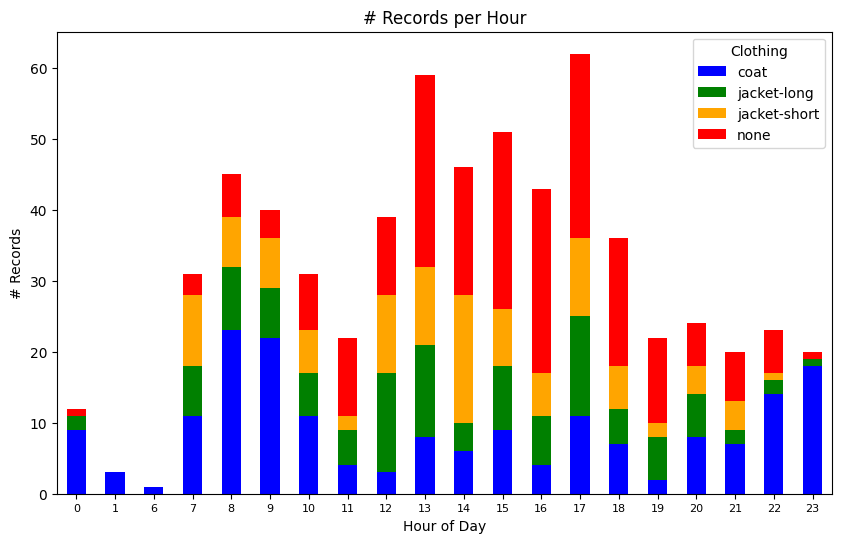

In [14]:
df_time = df[['Time', 'Outer Clothing']].copy()
df_time['Time'] = [int(time.split(':')[0]) for time in df_time['Time'].astype(str)]

time_group = df_time.groupby(['Time', 'Outer Clothing']).size().reset_index(name='Count')
pivot = time_group.pivot(index='Time', columns='Outer Clothing', values='Count')

ax = pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'green', 'orange', 'red'])
plt.title('# Records per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('# Records')
plt.xticks(rotation=0, size=8)
plt.legend(title='Clothing');

### Boxplots

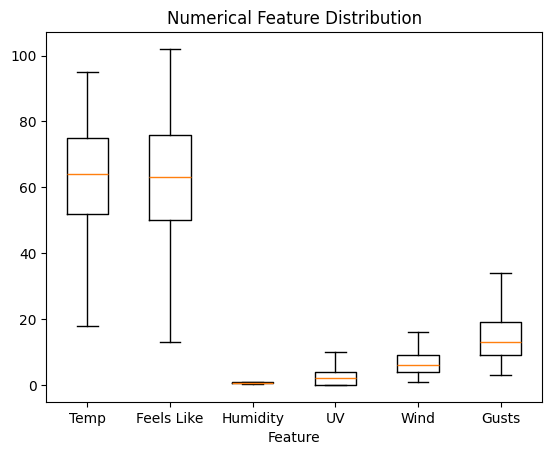

In [15]:
numeric_columns = df.select_dtypes(include=['number'])
plt.boxplot(numeric_columns, labels=numeric_columns.columns, showfliers=False)
plt.title('Numerical Feature Distribution')
plt.xlabel('Feature');

### Correlation Matrix

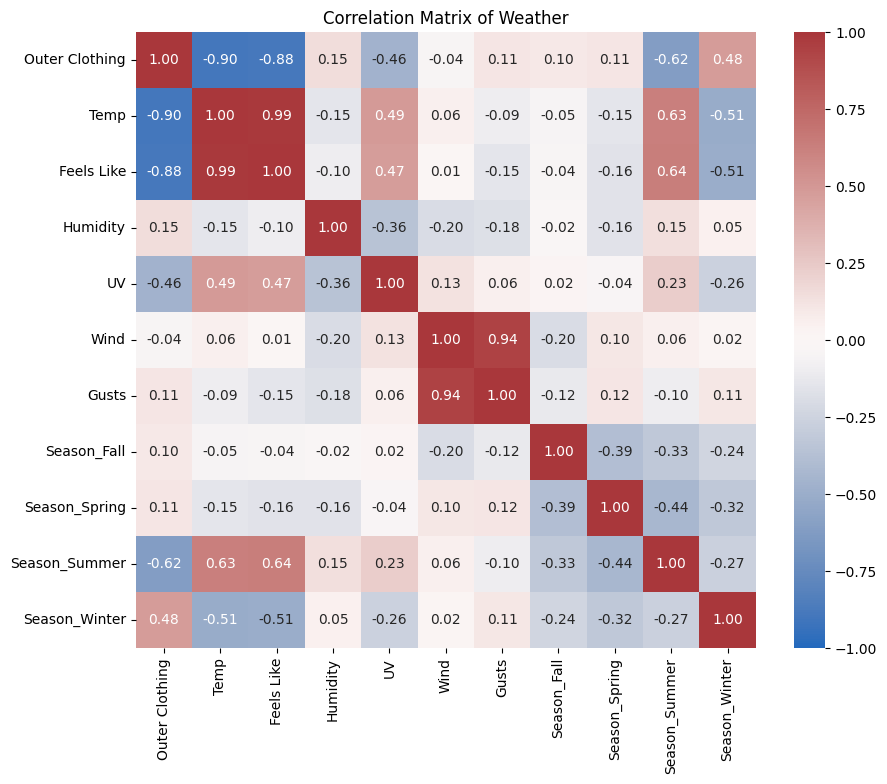

In [16]:
df_corr = df.copy()

# filter features
df_corr.replace({'none': 1, 'jacket-short': 2, 'jacket-long': 3, 'coat': 4}, inplace=True)
df_corr.drop(columns=['Date', 'Time'], inplace=True)
df_corr = pd.get_dummies(df_corr, columns=['Season'])
columns = ['Outer Clothing'] + [col for col in df_corr.columns if col != 'Outer Clothing']
df_corr = df_corr[columns]

# normalize numerical data
scaler = StandardScaler()
numeric_columns = df_corr.select_dtypes(include=['number']).columns
df_corr[numeric_columns] = scaler.fit_transform(df_corr[numeric_columns])

# get correlation matrix
corr_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    vmin=-1,
    vmax=1,
    fmt='.2f',
    annot=True,
    cmap='vlag'
)
plt.title("Correlation Matrix of Weather");

### Principal Component Analysis (PCA)

First we need to preprocess the data. We will be recycling the results from our
correlation matrix since the steps are similar. We just need to re-adjust the
target feature.

In [17]:
df_pca = df_corr.copy()
df_pca['Outer Clothing'] = df['Outer Clothing']
df_pca['Outer Clothing'].replace({'none': '1', 'jacket-short': '2', 'jacket-long': '3', 'coat': '4'}, inplace=True)

Next, we will start off with reducing features to just 2, which we can then plot
on a 2D scatter plot.

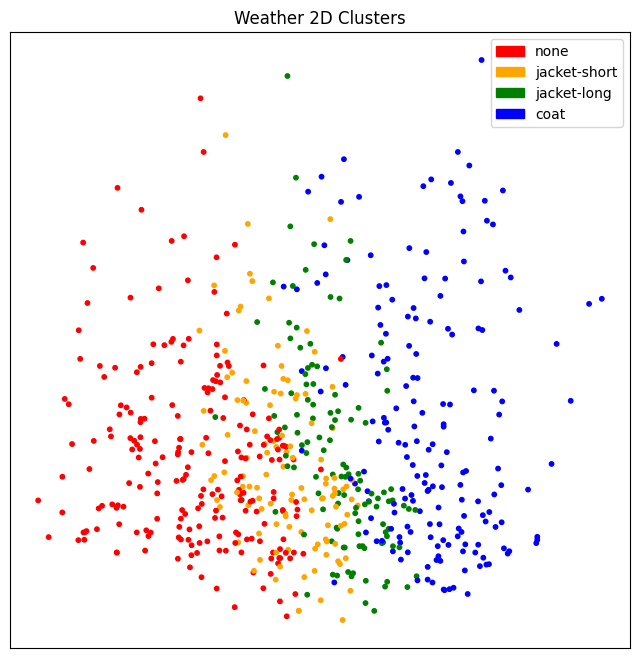

In [18]:
# reduce to 2 components
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(df_pca.drop(columns=['Outer Clothing']))

# custom color map
custom_cmap = mcolors.ListedColormap(COLOR_MAPPING.values())

# 2D scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=df_pca['Outer Clothing'].astype(int),
    s=10,
    cmap=custom_cmap,
)
ax.set_xticks([])
ax.set_yticks([])

# Add legend
handles = [mpatches.Patch(color=color, label=label) for label, color in COLOR_MAPPING.items()]
plt.legend(handles=handles, loc='best')
plt.title('Weather 2D Clusters');

Finally, we can expand on our code to plot on a 3D scatter plot instead.

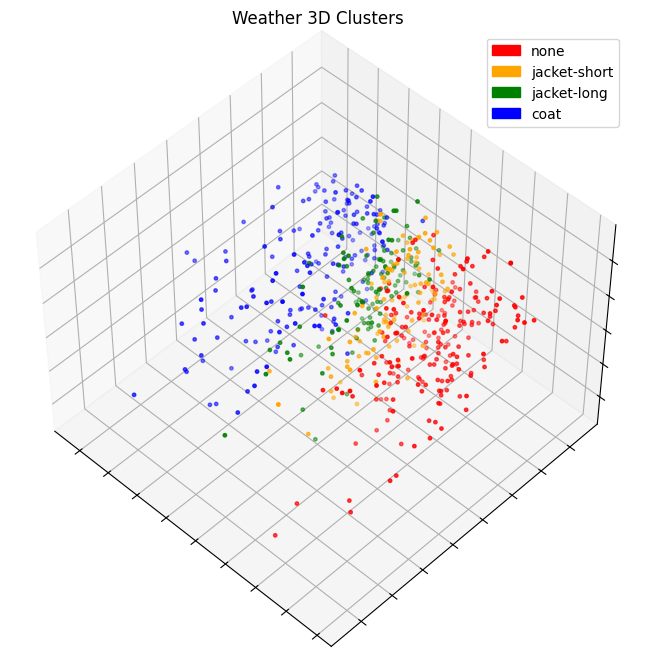

In [19]:
# reduce to 3 components
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(df_pca.drop(columns=['Outer Clothing']))

# custom color map
custom_cmap = mcolors.ListedColormap(COLOR_MAPPING.values())

# 3D scatter plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d', elev=48, azim=134)
ax.scatter(
    X_3d[:, 0],
    X_3d[:, 1],
    X_3d[:, 2],
    c=df_pca['Outer Clothing'].astype(int),
    s=6,
    cmap=custom_cmap
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

# legend & title
handles = [mpatches.Patch(color=color, label=label) for label,color in COLOR_MAPPING.items()]
plt.legend(handles=handles, loc='best')
plt.title('Weather 3D Clusters');

## Machine Learning Model Experiments

### ML Libraries

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

### Preprocess

In [21]:
df_ml = df.copy()
df_ml.head()

,Date,Time,Temp,Feels Like,Humidity,UV,Wind,Gusts,Outer Clothing,Season
0,2023-07-11,13:55,80,80,0.44,9,4,8.0,none,Summer
1,2023-07-12,12:44,83,83,0.45,9,4,8.0,none,Summer
2,2023-07-13,20:15,75,78,0.79,0,4,8.0,none,Summer
3,2023-07-17,17:38,82,83,0.49,3,5,9.0,none,Summer
4,2023-07-22,18:03,75,76,0.58,2,4,8.0,none,Summer


In [22]:
# drop Date and Time
df_ml.drop(columns=['Date', 'Time'], inplace=True)

# one-hot encode season
df_ml = pd.get_dummies(df_ml, columns=['Season'])

# split into X/y
X = df_ml.drop(columns=['Outer Clothing'])
y = df_ml['Outer Clothing']

# split off testing data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

# split rest into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, random_state=1234)

# normalize
numeric_columns = df_ml.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# print results
print('Train size:', X_train.shape[0])
print('Val size:', X_val.shape[0])
print('Test size:', X_test.shape[0])


Train size: 441
Val size: 126
Test size: 63


### Logistic Regression

In [23]:
lr_params = {
    'solver': ['saga', 'sag', 'newton-cg'],
    'penalty': [None, 'l2']
}

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    multi_class='multinomial',
    class_weight='balanced',
    n_jobs=-2,
    max_iter=2000
)

lr_grid = GridSearchCV(lr_model, lr_params, cv=5, scoring=['accuracy', 'f1_macro'], refit='f1_macro')
lr_grid.fit(X_train, y_train)

print('Logistic Regression Best Params:', lr_grid.best_params_)
print('Logistic Regression Best Score:', lr_grid.best_score_)

Logistic Regression Best Params: {'penalty': 'l2', 'solver': 'saga'}
Logistic Regression Best Score: 0.7852566519763071


### Decision Tree

In [24]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

dt_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring=['accuracy', 'f1_macro'], refit='f1_macro')
dt_grid.fit(X_train, y_train)

print('DecisionTree Best Params:', dt_grid.best_params_)
print('DecisionTree Best Score:', dt_grid.best_score_)

DecisionTree Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10}
DecisionTree Best Score: 0.7696188245629209


### KNN

In [25]:
knn_params = {
    'n_neighbors': np.arange(1, 16, 2),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4, 5],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

knn_model = KNeighborsClassifier(
    n_jobs=-2
)

knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring=['accuracy', 'f1_macro'], refit='f1_macro')
knn_grid.fit(X_train, y_train)

print('KNN Best Params:', knn_grid.best_params_)
print('KNN Best Score:', knn_grid.best_score_)

KNN Best Params: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
KNN Best Score: 0.722837734228558


### Neural Network

c:\Users\Me\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


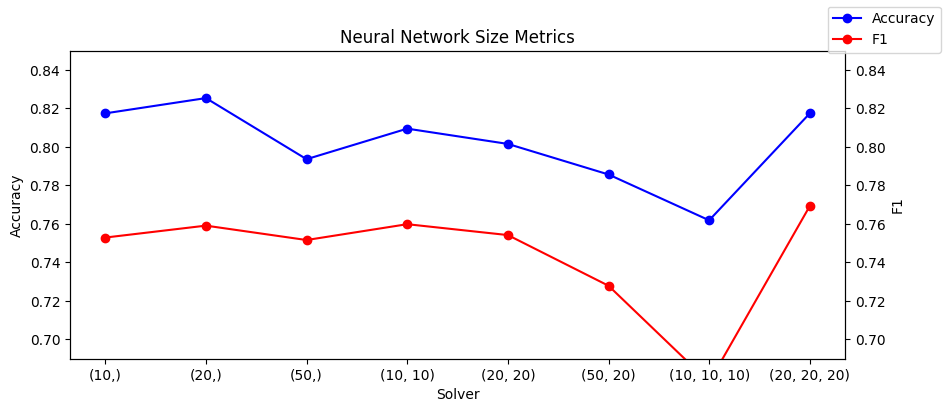

In [26]:
nn_sizes = [
    (10,), 
    (20,), 
    (50,), 
    (10, 10), 
    (20, 20), 
    (50, 20), 
    (10, 10, 10), 
    (20, 20, 20)
]

nn_size_acc = []
nn_size_f1 = []

for size in nn_sizes:
    mlp = MLPClassifier(
        random_state=RANDOM_STATE,
        max_iter=2000,
        hidden_layer_sizes=size
    )
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_val)
    nn_size_acc.append(accuracy_score(y_val, y_pred))
    nn_size_f1.append(f1_score(y_val, y_pred, average='macro'))

nn_sizes = [str(size) for size in nn_sizes]

fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(nn_sizes, nn_size_acc, 'b-', label='Accuracy', marker='o')
ax1.set_xlabel('Solver')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.69, 0.85)

ax2 = ax1.twinx()
ax2.plot(nn_sizes, nn_size_f1, 'r-', label='F1', marker='o')
ax2.set_ylabel('F1')
ax2.set_ylim(0.69, 0.85)

plt.title('Neural Network Size Metrics')
fig.legend(loc='upper right');

In [27]:
nn_params = {
    'hidden_layer_sizes' : [
        (20, 20, 20)
    ],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001, 0.01]
}

nn_model = MLPClassifier(
    random_state=RANDOM_STATE,
    max_iter=2000
)

nn_grid = GridSearchCV(nn_model, nn_params, cv=5, scoring=['accuracy', 'f1_macro'], refit='f1_macro')
nn_grid.fit(X_train, y_train)

print('Neural Network Best Params:', nn_grid.best_params_)
print('Neural Network Best Score:', nn_grid.best_score_)

Neural Network Best Params: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (20, 20, 20), 'solver': 'adam'}
Neural Network Best Score: 0.802364082793213


## Compare Performance

### Scoring Function
To compare the performance across the different model types, I'll first define a
helper method to score a model. It reports several metrics for the model as well
as creating a confusion matrix.

In [28]:
def score_model(y_true: pd.Series, y_pred: np.ndarray, label: str) -> None:
    # calc matrics
    acc = accuracy_score(y_true, y_pred)
    p = precision_score(y_true, y_pred, average="macro")
    r = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")

    # print metrics
    print(f'Params: {label}')
    print(' - Accuracy: ', acc)
    print(' - Precision:', p)
    print(' - Recall:   ', r)
    print(' - F1:       ', f1)

    # display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['coat', 'jacket-long', 'jacket-short', 'none'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{label}')
    plt.show()

    # return metrics
    return acc, p, r, f1

### Logistic Regression

Params: Best Logistic Regression
 - Accuracy:  0.7857142857142857
 - Precision: 0.7304835202502222
 - Recall:    0.7277661064425771
 - F1:        0.7264507028551972


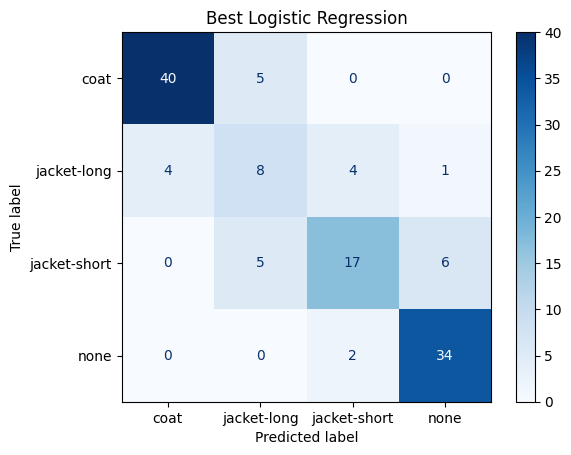

In [29]:
best_lr = LogisticRegression(
    random_state=RANDOM_STATE,
    multi_class='multinomial',
    class_weight='balanced',
    penalty='l2',
    solver='saga',
    n_jobs=-2,
    max_iter=2000
)

best_lr.fit(X_train, y_train)
lr_ypred = best_lr.predict(X_val)
lr_results = score_model(lr_ypred, y_val, label='Best Logistic Regression')

### Decision Tree

Params: Best Decision Tree
 - Accuracy:  0.7142857142857143
 - Precision: 0.6793665713336976
 - Recall:    0.6818673487030485
 - F1:        0.6714616247949582


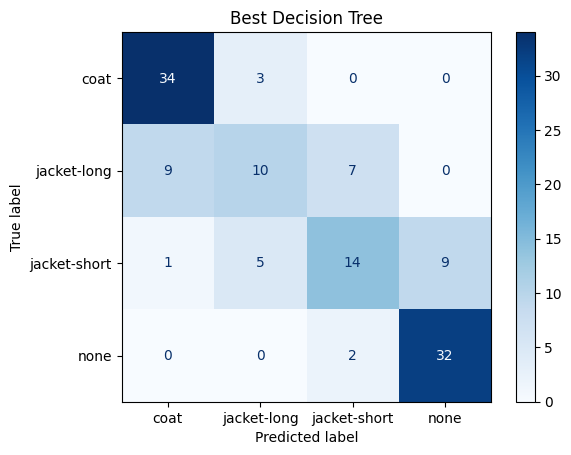

In [30]:
best_dt = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    criterion='entropy',
    max_depth=10,
    max_features=None,
    min_samples_leaf=10
)

best_dt.fit(X_train, y_train)
lr_ypred = best_dt.predict(X_val)
dt_results = score_model(lr_ypred, y_val, label='Best Decision Tree')

### KNN

Params: Best KNN
 - Accuracy:  0.8174603174603174
 - Precision: 0.764782635474576
 - Recall:    0.7736542443064182
 - F1:        0.759966867899497


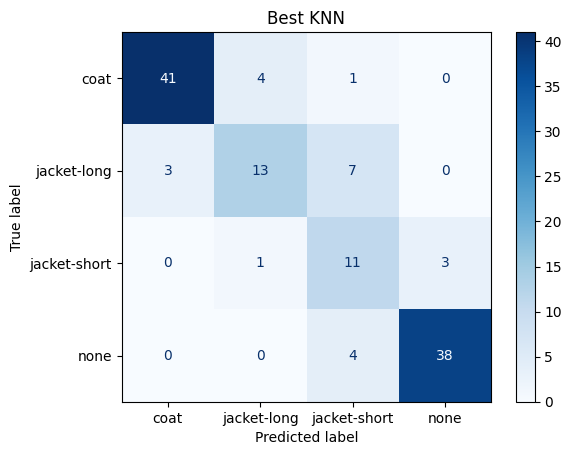

In [31]:
best_knn = KNeighborsClassifier(
    algorithm='ball_tree',
    n_neighbors=5,
    p=1,
    weights='distance',
    n_jobs=-2
)

best_knn.fit(X_train, y_train)
lr_ypred = best_knn.predict(X_val)
knn_results = score_model(lr_ypred, y_val, label='Best KNN')

### Neural Network

Params: Best Neural Network
 - Accuracy:  0.7857142857142857
 - Precision: 0.7092270799190205
 - Recall:    0.7185708371847727
 - F1:        0.7094850948509486


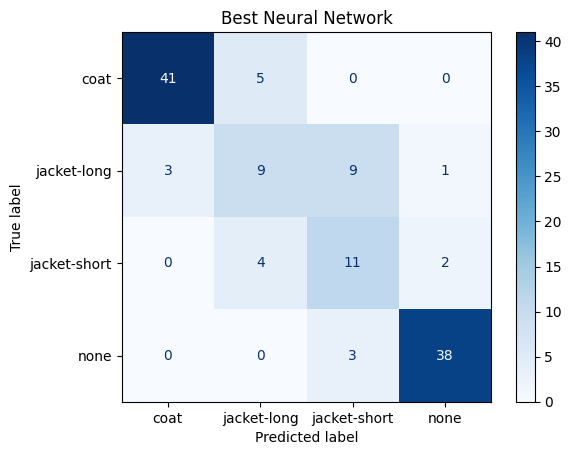

In [32]:
best_nn = MLPClassifier(
    random_state=RANDOM_STATE,
    hidden_layer_sizes=(20, 20, 20),
    max_iter=2000,
    activation='logistic',
    alpha=0.001,
    solver='adam'
)

best_nn.fit(X_train, y_train)
lr_ypred = best_nn.predict(X_val)
nn_results = score_model(lr_ypred, y_val, label='Best Neural Network')

### Results


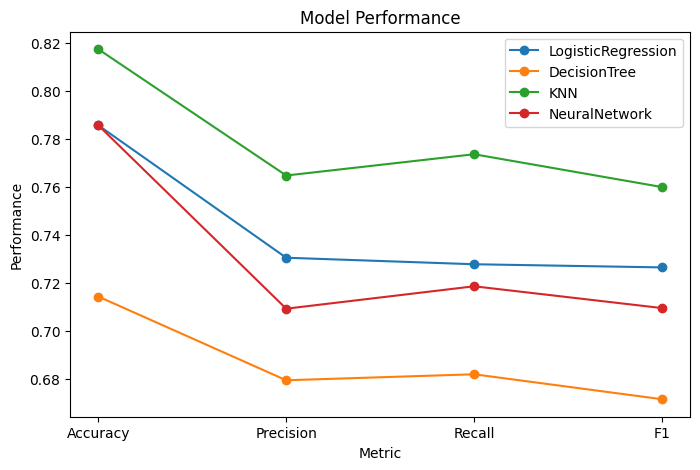

In [ ]:
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1']
models = ['LogisticRegression', 'DecisionTree', 'KNN', 'NeuralNetwork']
metrics = np.array([lr_results, dt_results, knn_results, nn_results]).T

fig, ax = plt.subplots(figsize=(8,5))
for i, label in enumerate(models):
    ax.plot(
        metric_labels,
        metrics[:, i],
        marker='o',
        label=label
    )

ax.set_xlabel('Metric')
ax.set_ylabel('Performance')
ax.set_title('Model Performance')
ax.legend()
plt.show()

It appears that KNN performs the best. Now I can check the final test performance.

Params: Final Best Model
 - Accuracy:  0.7777777777777778
 - Precision: 0.7209690893901419
 - Recall:    0.721091189512242
 - F1:        0.7135737069947596


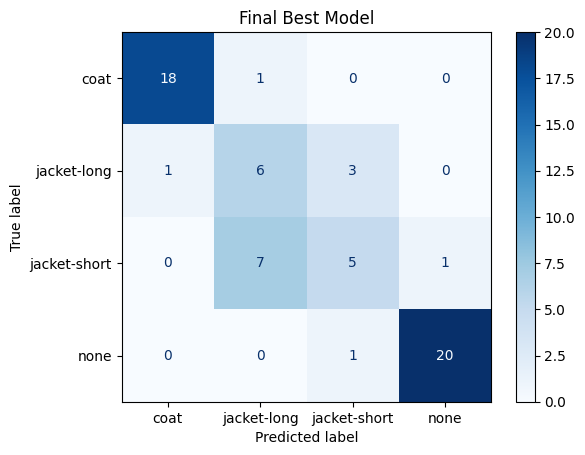

(0.7777777777777778, 0.7209690893901419, 0.721091189512242, 0.7135737069947596)

In [ ]:
best_model = best_knn
y_pred = best_model.predict(X_test)
score_model(y_pred, y_test, label='Final Best Model')

## Export Model
I can now export the best model to be used in a runner program.

In [37]:
import joblib

joblib.dump(scaler, 'models/best.scaler')
joblib.dump(best_model, 'models/best.model');